#Ingestão e validação de dados usando Pipeline no TFX

Nesse notebook iremos criar e executar um Pipeline do TFX para validar novos dados de entrada baseados em uma distribuição previamente conhecida. Esse notebook foi baseado em: [Data validation using TFX Pipeline and TensorFlow Data Validation](https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/tfx/penguin_tfdv.ipynb).

## Introdução

### Motivação

Vamos imaginar o seguinte cenário: colocamos em produção um modelo de machine learning que sabe classificar animais domésticos. Quando treinamos esse modelo, na nossa base de treino, tínhamos fotos de gatos e cachorros. Sendo assim, nosso modelo aprendeu a classificar gato e cachorro, ou seja, esse era o "mundo" que ele conhecia.

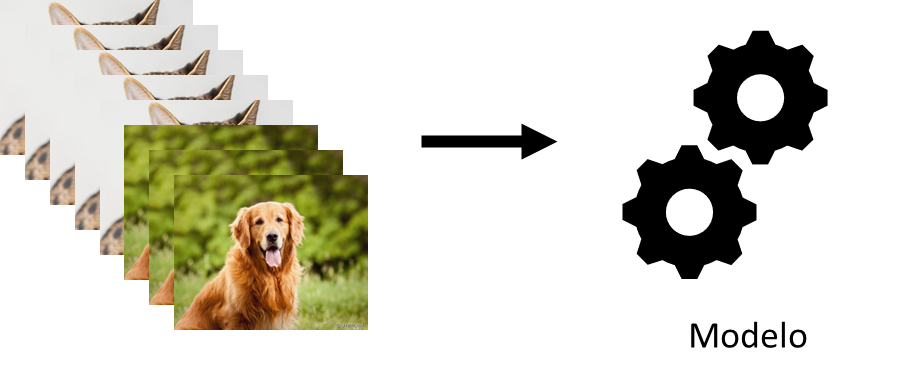

Então, disponibilizamos esse modelo para os usuários poderem classificar seus animais. A partir desse momento, que colocamos em produção, verificamos que esse modelo não estava apresentando bons resultados e quando fomos estudar mais a fundo o motivo, foi percebido que os usuários não estavam só enviando fotos de gatos e cachorros, mas também de coelhos, peixes, etc. Ou seja, a distribuição esperada dos dados mudou! Esse conceito é conhecido como **_data drift_**.

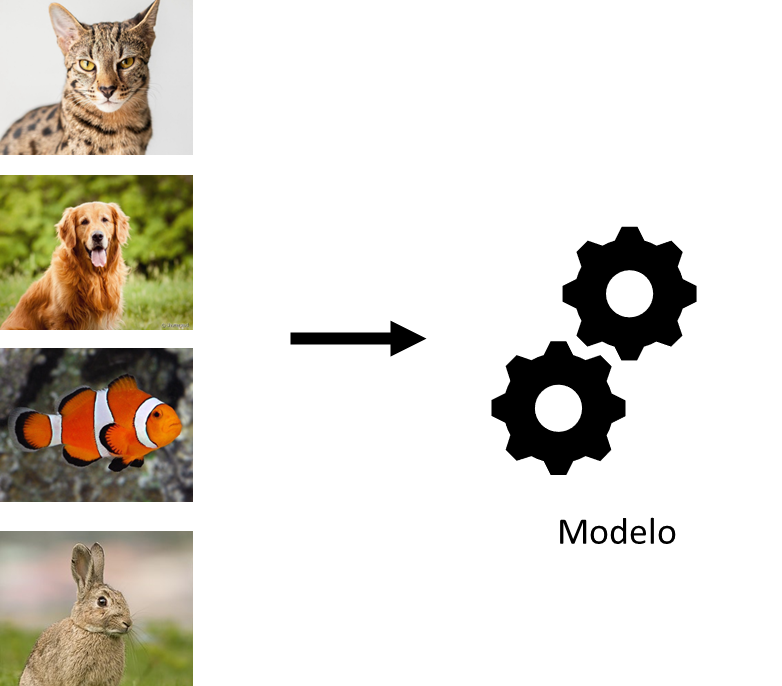

Dessa forma, é muito importante que se tenha um "dataset de controle", do qual iremos extrair as informações referentes ao tipo de dado esperado e também aos intervalos/distribuições esperadas, e iremos usá-lo para avaliar se outros datasets se comportam de maneira similar.

Pegando o gancho do que vimos na aula passada ([Componentes de ingestão e validação de dados](https://colab.research.google.com/drive/1KfLhgcGFkFZ0LaE_Z3VbM-9gosMhwKW4?authuser=2)), precisamos gerar um componente SchemaGen de controle e importá-lo!

### Pipeline que iremos construir

#### Pipeline de controle

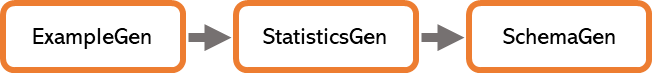

#### Pipeline (início) de treino/predição

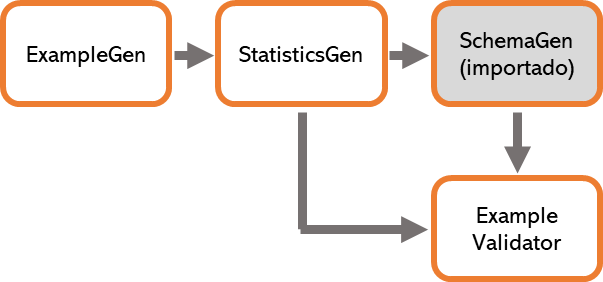

## Execução

### Configuração do ambiente

In [ ]:
# Garantir que temos a biblioteca colab e que o pip está atualizado
try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
# Instalando TFX
!pip install -U tfx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Após a instalação, reinicie seu ambiente para garantir que o Colab veja o TFX. Para isso, clique em "Ambiente de execução" $\rightarrow$ "Reiniciar ambiente de execução".

Feito isso, comece a executar a partir da próxima célula.

In [ ]:
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TFX version: 1.7.1


### Utils

In [ ]:
from ml_metadata.proto import metadata_store_pb2
# Non-public APIs, just for showcase.
from tfx.orchestration.portable.mlmd import execution_lib

# TODO(b/171447278): Move these functions into the TFX library.

def get_latest_artifacts(metadata, pipeline_name, component_id):
  """Output artifacts of the latest run of the component."""
  context = metadata.store.get_context_by_type_and_name(
      'node', f'{pipeline_name}.{component_id}')
  executions = metadata.store.get_executions_by_context(context.id)
  latest_execution = max(executions,
                         key=lambda e:e.last_update_time_since_epoch)
  return execution_lib.get_artifacts_dict(metadata, latest_execution.id,
                                          [metadata_store_pb2.Event.OUTPUT])

# Non-public APIs, just for showcase.
from tfx.orchestration.experimental.interactive import visualizations

def visualize_artifacts(artifacts):
  """Visualizes artifacts using standard visualization modules."""
  for artifact in artifacts:
    visualization = visualizations.get_registry().get_visualization(
        artifact.type_name)
    if visualization:
      visualization.display(artifact)

from tfx.orchestration.experimental.interactive import standard_visualizations
standard_visualizations.register_standard_visualizations()

### Iniciando nosso experimento

In [ ]:
import os

# Vamos definir os nomes dos nossos pipelines para definirmos
# as pastas onde iremos salvas os artefatos gerados
PIPELINE_CONTROLE = "iris_controle"
PIPELINE = "iris_usuario"

# Pastas onde iremos salvar os outputs
PIPELINE_CONTROLE_ROOT = os.path.join('pipelines', PIPELINE_CONTROLE)
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE)

# Caminho para o banco de dados SQLite que usaremos como nosso banco de metadata
METADATA_CONTROLE_PATH = os.path.join('metadata', PIPELINE_CONTROLE,
                                    'metadata.db')
METADATA_PIPELINE_PATH = os.path.join('metadata', PIPELINE, 'metadata.db')

#### Preparando os dados


In [ ]:
import urllib.request
import tempfile

DATA_ROOT = tempfile.mkdtemp(prefix='tfx-data')  # Criando pasta temporária
_data_url = 'https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/datasets/iris.csv'
_data_filepath = os.path.join(DATA_ROOT, "data.csv")
urllib.request.urlretrieve(_data_url, _data_filepath)

('/tmp/tfx-dataf7sa9l1e/data.csv', <http.client.HTTPMessage at 0x7fd40e2de410>)

In [ ]:
import pandas as pd

df = pd.read_csv(_data_filepath, index_col=0)
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


Vamos simular um caso de base de treino e dados reais vindos dos usuários. Para isso, iremos separar nossa base em duas.
Nesse nosso exeplo não temos modelos, por isso não estamos interessados em base de validação.

In [ ]:
df = df.sample(frac=1)
df.shape

(150, 5)

In [ ]:
df_controle = df.iloc[:100]
df_usuario = df.iloc[100:]

In [ ]:
!mkdir data_controle
!mkdir data_usuario

In [ ]:
df_controle.to_csv('data_controle/iris_controle.csv', index = False)
df_usuario.to_csv('data_usuario/iris_usuario.csv', index = False)

### Escrevendo nosso pipeline de controle

In [ ]:
from tfx.proto import example_gen_pb2
from tfx.v1.proto import Output, SplitConfig

In [ ]:
def _create_schema_pipeline(pipeline_name: str,
                            pipeline_root: str,
                            data_root: str,
                            metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""
  # Ingestão de dados
  # Configuração para gerar apenas um conjunto (não dividir em treino e teste)
  output = Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 SplitConfig.Split(name='train', hash_buckets=1)
             ]))
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, output_config=output)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

Executando a Pipeline

In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_schema_pipeline(
      pipeline_name=PIPELINE_CONTROLE,
      pipeline_root=PIPELINE_CONTROLE_ROOT,
      data_root='data_controle',
      metadata_path=METADATA_CONTROLE_PATH))

In [ ]:
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

# Conectando ao banco de dados de metadata
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_CONTROLE_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  
  # Pegando a ultima execução do StatisticsGen
  stat_gen_output = get_latest_artifacts(metadata_handler, PIPELINE_CONTROLE,
                                         'StatisticsGen')
  stats_artifacts = stat_gen_output[standard_component_specs.STATISTICS_KEY]

  # Pegando a ultima execução do SchemaGen
  schema_gen_output = get_latest_artifacts(metadata_handler,
                                           PIPELINE_CONTROLE, 'SchemaGen')
  schema_artifacts = schema_gen_output[standard_component_specs.SCHEMA_KEY]

In [ ]:
visualize_artifacts(stats_artifacts)

In [ ]:
visualize_artifacts(schema_artifacts)

,Type,Presence,Valency,Domain
Feature name,,,,
'Species',STRING,required,,'Species'
'Petal.Length',FLOAT,required,,-
'Petal.Width',FLOAT,required,,-
'Sepal.Length',FLOAT,required,,-
'Sepal.Width',FLOAT,required,,-


,Values
Domain,
'Species',"'setosa', 'versicolor', 'virginica'"


### Exportando o Schema gerado

Agora que geramos o schema para nossa base de controle, precisamos exportá-lo para utilizar em nosso outro pipeline. Para isso, iremos pegar o caminho do artefato gerado na última execução e copiar o arquivo .pbtxt para um local conhecido.

In [ ]:
schema_artifacts[0].uri

'pipelines/iris_controle/SchemaGen/schema/6'

In [ ]:
import shutil

_schema_filename = 'schema.pbtxt'
SCHEMA_PATH = 'schema'

os.makedirs(SCHEMA_PATH, exist_ok=True)
_generated_path = os.path.join(schema_artifacts[0].uri, _schema_filename)

# Copiando
shutil.copy(_generated_path, SCHEMA_PATH)

'schema/schema.pbtxt'

### Criando nosso pipeline (início) de treino/predição

In [ ]:
def _create_pipeline(pipeline_name: str,
                     pipeline_root: str,
                     data_root: str,
                     schema_path: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline using predefined schema with TFX."""
  # Ingestão de dados
  # Configuração para gerar apenas um conjunto (não dividir em treino e teste)
  output = Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 SplitConfig.Split(name='user_data', hash_buckets=1)
             ]))
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, output_config=output)

  # Computes statistics over data for visualization and example validation.
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Importar schema
  schema_importer = tfx.dsl.Importer(
      source_uri=schema_path,
      artifact_type=tfx.types.standard_artifacts.Schema).with_id(
          'schema_importer')

  # Valida dados com schema e procura por anomalias/possiveis erros
  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_importer.outputs['result'])

  components = [
      example_gen,
      statistics_gen,
      schema_importer,
      example_validator,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='data_usuario',
      schema_path=SCHEMA_PATH,
      metadata_path=METADATA_PIPELINE_PATH))

In [ ]:
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PIPELINE_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  ev_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                   'ExampleValidator')
  anomalies_artifacts = ev_output[standard_component_specs.ANOMALIES_KEY]

In [ ]:
visualize_artifacts(anomalies_artifacts)

,Anomaly short description,Anomaly long description
Feature name,,
'\'Petal.Length\'',Out-of-range values,Unexpectedly high value: 6.9>1(upto six significant digits)


### Gerando anomalias

In [ ]:
!mkdir new_data

In [ ]:
df_usuario.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
27,5.0,3.4,1.6,0.4,setosa
12,4.8,3.4,1.6,0.2,setosa
120,6.0,2.2,5.0,1.5,virginica
44,5.0,3.5,1.6,0.6,setosa
143,5.8,2.7,5.1,1.9,virginica


In [ ]:
df_usuario.loc[df_usuario.head().index, 'Species'] = 'new_specie'
df_usuario.to_csv('new_data/data_usuario.csv', index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='new_data',
      schema_path=SCHEMA_PATH,
      metadata_path=METADATA_PIPELINE_PATH))

In [ ]:
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PIPELINE_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  ev_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                   'ExampleValidator')
  anomalies_artifacts = ev_output[standard_component_specs.ANOMALIES_KEY]

In [ ]:
visualize_artifacts(anomalies_artifacts)

,Anomaly short description,Anomaly long description
Feature name,,
'\'Petal.Length\'',Out-of-range values,Unexpectedly high value: 6.9>1(upto six significant digits)
'Species',Unexpected string values,Examples contain values missing from the schema: new_specie (~10%).
